In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Load the file in a Data Frame
file = 'new_dataset_1.txt'
df = pd.read_csv(file,sep="\t", header=None)

In [2]:
#Guassian Kernel Similarity
def Guassian_Kernel(x1, x2, sigma):
    diff =np.matrix(abs(np.subtract(x1, x2)))
    
    square = (np.square(diff).sum(axis=1))
    
    return np.exp(-(square)/(2*sigma**2))

In [3]:
#Spectral Eigen Values
def Spectral_Eigen(k, lap, eigen_gap):
    eigen_val, eigen_vec = linalg.eig((lap))
    eigen_gap = np.argmax(np.diff(eigen_val.real))
    sorted_eigen_val = np.sort(eigen_val.real)[::-1]
    count = eigen_gap + 1
    index = eigen_val.real.argsort()[:count]
    transform = np.ndarray(shape=(lap.shape[0],0))
    
    for i in range(1, index.shape[0]):
        similarity_eigen_vec = np.transpose(np.matrix(eigen_vec[:,index.item(i)]))
        transform = np.concatenate((transform, similarity_eigen_vec), axis=1)
    return transform, eigen_gap

In [4]:
#Spectral Values
def Spectral(k, lap):
    eigen_val, eigen_vec = linalg.eig((lap))
    index = eigen_val.real.argsort()[:k]
    transform = np.ndarray(shape=(lap.shape[0],0))
    
    for i in range(1, index.shape[0]):
        similarity_eigen_vec = np.transpose(np.matrix(eigen_vec[:,index.item(i)]))
        transform = np.concatenate((transform, similarity_eigen_vec), axis=1)
    return transform

In [5]:
#Plotting the clusters
def plots(pca_data,assigned_cluster,file):
    df_new = pd.DataFrame({'y1':np.array(pca_data)[:,0], 'y2':np.array(pca_data)[:,1], 'clusters': assigned_cluster})
    sns.lmplot(x='y1', y='y2', data=df_new, fit_reg=False,hue='clusters',palette = 'dark', height=5,aspect = 1.5,legend_out = False)
    plt.title(file)

In [6]:
#Incident Matrix
def get_matrix(cluster_values):
    mat = np.zeros((len(cluster_values),len(cluster_values)))
    for i in range(len(cluster_values)):
        for j in range(len(cluster_values)):
                if(cluster_values[i] == cluster_values[j]):
                    mat[i][j] = 1
                else:
                    mat[i][j] = 0
    return mat

#Calculating m values using ground truth values and kmeans values
def external_index(ground_matrix, Spectral_mat):
    m11 = 0
    m00 = 0
    m01 = 0
    m10 = 0
    for i in range(len(ground_matrix)):
        for j in range(len(Spectral_mat)):
            if Spectral_mat[i][j] == 1 and ground_matrix[i][j] == 1:
                m11 += 1
            elif Spectral_mat[i][j] == 0 and ground_matrix[i][j] == 0:
                m00 += 1
            elif Spectral_mat[i][j] == 0 and ground_matrix[i][j] == 1:
                m01 += 1
            elif Spectral_mat[i][j] == 1 and ground_matrix[i][j] == 0:
                m10 += 1
    return m11, m00, m01, m10

Enter the number of clusters: 
3
Enter the sigma value:
2
Laplacian matrix
[[65.19454204 66.0896685  65.34026523 ... 66.03027305 66.16330811
  66.08993036]
 [66.0896685  65.19454204 66.15719494 ... 65.25864518 65.36447599
  65.23134763]
 [65.34026523 66.15719494 65.19454204 ... 66.12623552 66.1863431
  66.15719494]
 ...
 [66.03027305 65.25864518 66.12623552 ... 65.19454204 65.50725277
  65.2748809 ]
 [66.16330811 65.36447599 66.1863431  ... 65.50725277 65.19454204
  65.43020773]
 [66.08993036 65.23134763 66.15719494 ... 65.2748809  65.43020773
  65.19454204]]
1. Type a to enter centroid indices 
2. Type b to randomly select indices 
3. Type c for EigenGap values
a
Enter the point :1
1
Enter the point :2
4
Enter the point :3
8


<ipython-input-7-84cbce521708>:40: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  kmeans = KMeans(n_clusters=k, init = center_data).fit(transform.real)


Spectral Clustering Results
-------------------------------------------------------------
Rand Index for file new_dataset_1.txt is 0.6075555555555555
Jaccard Coefficient for file new_dataset_1.txt is 0.30186590765338395


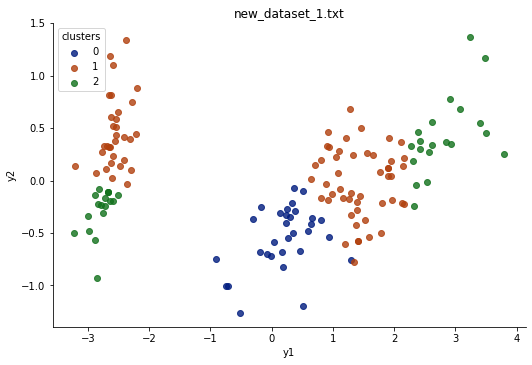

In [7]:
#Main Function
def __main__():
    print('Enter the number of clusters: ')
    k = int(input())
    print('Enter the sigma value:')
    sigma = float(input())
    eigen_gap = 0
    
    #ground truth values
    gr_true_values = df[1]

    #Gene Data
    gene_data = df.iloc[:,2:].to_numpy().astype(np.float)

    #Similarity Matrix
    Similarity_mat = np.matrix(np.full((gene_data.shape[0] , gene_data.shape[0]) , 0 , dtype=float))
    for i in range(gene_data.shape[0]):
        for j in range(gene_data.shape[0]):
            Similarity_mat[i ,j] = Guassian_Kernel(gene_data[i,:] , gene_data[j , :] , sigma)

    #Diagonal Matrix
    Diag_mat = np.diag(Similarity_mat.sum(axis=1))
    
    #Laplacian matrix
    Laplacian = Diag_mat - Similarity_mat
    print("Laplacian matrix")
    print(Laplacian)
    
    #Transforming to new embedded space
    print("1. Type a to enter centroid indices \n2. Type b to randomly select indices \n3. Type c for EigenGap values")
    option = input()
    if(option == 'a'):
        centroids = []
        transform = Spectral(k, Laplacian)
        for i in range(k):
            print("Enter the point :"+str(i+1))
            centroids.append(input())
        centroids = [int(ele)-1 for ele in centroids]
        center_data = transform[centroids, :]
        kmeans = KMeans(n_clusters=k, init = center_data).fit(transform.real)
    elif (option == 'b'):
        transform = Spectral(k, Laplacian)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(transform.real)
    elif (option == 'c'):
        transform,eigen_gap = Spectral_Eigen(k, Laplacian, eigen_gap)
        print("number of clusters = {}".format(eigen_gap+1))
        kmeans = KMeans(n_clusters=eigen_gap+1, random_state=0).fit(transform.real)
    else:
        print("Invalid option")
        
    #Cluster Assignment
    Assigned_cluster = kmeans.labels_
    
    #PCA part
    pca_data = PCA(n_components=2).fit_transform(gene_data)

    #Scatter Plots
    plots(pca_data,Assigned_cluster,file)
    
    #Incident Matrices for both Ground truth values and Spectral Cluster values
    ground_matrix = get_matrix(gr_true_values.to_numpy())
    Spectral_mat = get_matrix(np.array(Assigned_cluster))

    #External_indices
    m11,m00,m01, m10 = external_index(ground_matrix,Spectral_mat)

    #Rand Index
    rand_index = (m11 + m00)/(m11 + m00 + m01 + m10)

    #Jaccard Coefficient
    j_coeff = (m11)/(m11 + m10 + m01)

    print("Spectral Clustering Results")
    print("-------------------------------------------------------------")
    print("Rand Index for file {} is {}".format(file,str(rand_index)))
    print("Jaccard Coefficient for file {} is {}".format(file,str(j_coeff)))

__main__()